<h1 style="text-align: center;">Appendix

Please be advised that this Notebook has been designed to offer a high level of automation, allowing for easy modification of data and variables. I have taken care to provide annotations detailing my thought process, as well as docstrings for key functions to facilitate your understanding and use of the code.

### Import libraries and set constants

In [1]:
import json
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
# FRED_API_Key is a Python file I created, it includes my API key as a variable called "api_key"
# Please replace the api_key with your own FRED API key when running the following code
import FRED_API_Key
api_key = FRED_API_Key.api_key

SERIES_ID_LIST = [1, 2, 3, 5, 7, 10] # the numbers after "GS" in the series ID

### Data Retrieval

In [3]:
def get_6_series(api_key, units="lin"):
    """
    Retrieves the six U.S. Treasury securities data series using the FRED API.
    
    Parameters:
    - api_key (str): a string representing the FRED API key
    - units (str): a string representing the unit of observation of the data, default is "lin"
    
    Returns:
    - data (pd.DataFrame): a pandas DataFrame containing the retrieved data series and date
    """
    series_list = []
    for i in SERIES_ID_LIST:
        series_list.append(get_dataframe("GS{i}".format(i = i), api_key, units))
    
    res = series_list[0]
    for series in series_list[1:]:
        res = res.merge(series, on='date')
    
    return res


# Helper functions:
def get_response(series_id, api_key, units):
    url = "https://api.stlouisfed.org/fred/series/observations?" + \
          "series_id={series_id}&api_key={api_key}&units={units}&file_type=json"
    url_formatted = url.format(series_id = series_id, api_key = api_key, units = units)
    
    response = requests.get(url_formatted)
    if response.status_code != 200:
        raise Exception("Bad response from API, status code = {}".format(response.status_code))
    return response
    
def get_dataframe(series_id, api_key, units):
    response = get_response(series_id, api_key, units)
    data = pd.DataFrame(response.json()['observations'])[['date', 'value']].iloc[1:]\
             .assign(date = lambda cols: pd.to_datetime(cols['date']))\
             .assign(value = lambda cols: cols['value'].astype(float))\
             .rename(columns = {'value': series_id})
    
    return data

In [4]:
# The function get_6_series can retrieve the six series data from FRED, 
# the unit is 'chg', meaning we are asking for the monthly changes of the six series
data = get_6_series(api_key, 'chg')
data

,date,GS1,GS2,GS3,GS5,GS7,GS10
0,1976-07-01,-0.32,-0.21,-0.19,-0.12,-0.05,-0.03
1,1976-08-01,-0.20,-0.22,-0.26,-0.18,-0.12,-0.06
2,1976-09-01,-0.16,-0.21,-0.20,-0.18,-0.17,-0.18
3,1976-10-01,-0.34,-0.44,-0.42,-0.38,-0.25,-0.18
4,1976-11-01,-0.21,-0.17,-0.15,-0.23,-0.30,-0.12
...,...,...,...,...,...,...,...
554,2022-09-01,0.61,0.61,0.65,0.67,0.66,0.62
555,2022-10-01,0.54,0.52,0.50,0.48,0.45,0.46
556,2022-11-01,0.30,0.12,-0.04,-0.12,-0.10,-0.09
557,2022-12-01,-0.05,-0.21,-0.29,-0.30,-0.27,-0.27


### Data Exploration

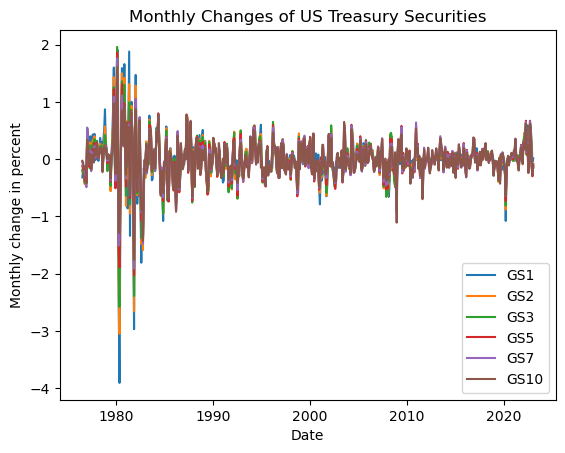

In [5]:
fig, ax = plt.subplots()

# plot each series on the same graph
for col in data.columns[1:]:
    ax.plot(data['date'], data[col], label=col)

# set axis labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Monthly change in percent')
plt.title('Monthly Changes of US Treasury Securities')
ax.legend()
plt.show()

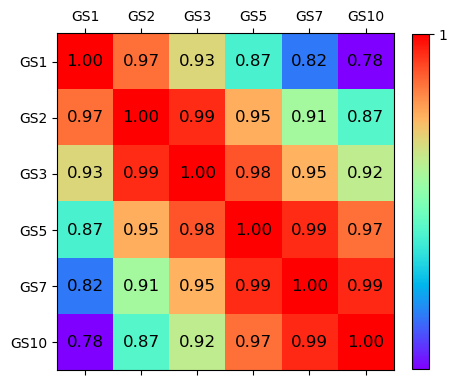

In [6]:
# Correlation matrix of the monthly changes of the securities yields

# np.corrcoef method views each row of the data as a variable, each column as an observation
# We need to take the transpose of data
corr_mat = np.corrcoef(data[data.columns[1:]].T)
img = plt.matshow(corr_mat, cmap=plt.cm.rainbow)
plt.colorbar(img, ticks = [-1, 0, 1], fraction=0.045)

# Set tick labels
plt.xticks(range(len(SERIES_ID_LIST)), ["GS" + str(x) for x in SERIES_ID_LIST])
plt.yticks(range(len(SERIES_ID_LIST)), ["GS" + str(x) for x in SERIES_ID_LIST])

# Add correlation values to plot
for x in range(corr_mat.shape[0]):
    for y in range(corr_mat.shape[1]):
        plt.text(x, y, "%0.2f" % corr_mat[x,y], size=12, color='black', ha="center", va="center")
        
plt.show()

### PCA on the entire dataset

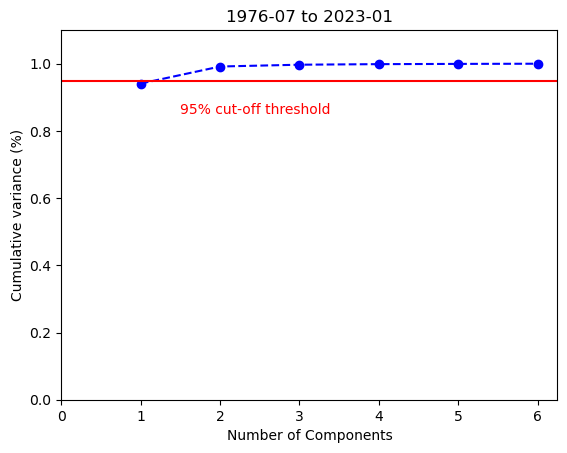

In [7]:
# Then we need to choose how many components to include in the PCA model

def select_num_pc(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_pca = scaler.fit_transform(data[data.columns[1:]])
    pca = PCA().fit(data_pca)

    xi = np.arange(1, 7, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker='o', linestyle='--', color='b')

    plt.xlabel('Number of Components')
    plt.xticks(np.arange(0, 7, step=1))
    plt.ylabel('Cumulative variance (%)')
    plt.title(data.iloc[0]['date'].strftime('%Y-%m') + ' to ' + \
              data.iloc[-1]['date'].strftime('%Y-%m'))

    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.text(1.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=10)

    ax.grid(axis='x')
    
    
select_num_pc(data)

Date Range:  1976-07 to 2023-01
Singular Values:  [9.39243945 2.18025805]
Variance Explained by Each PC:  [0.94102199 0.05070593]
Total Variance Explained:  0.9917279249899535
Loadings:  
           0         1         2         3         4         5
0 -0.341039 -0.388491 -0.407591 -0.439411 -0.431493 -0.432861
1 -0.634561 -0.389532 -0.184457  0.150289  0.369107  0.502739


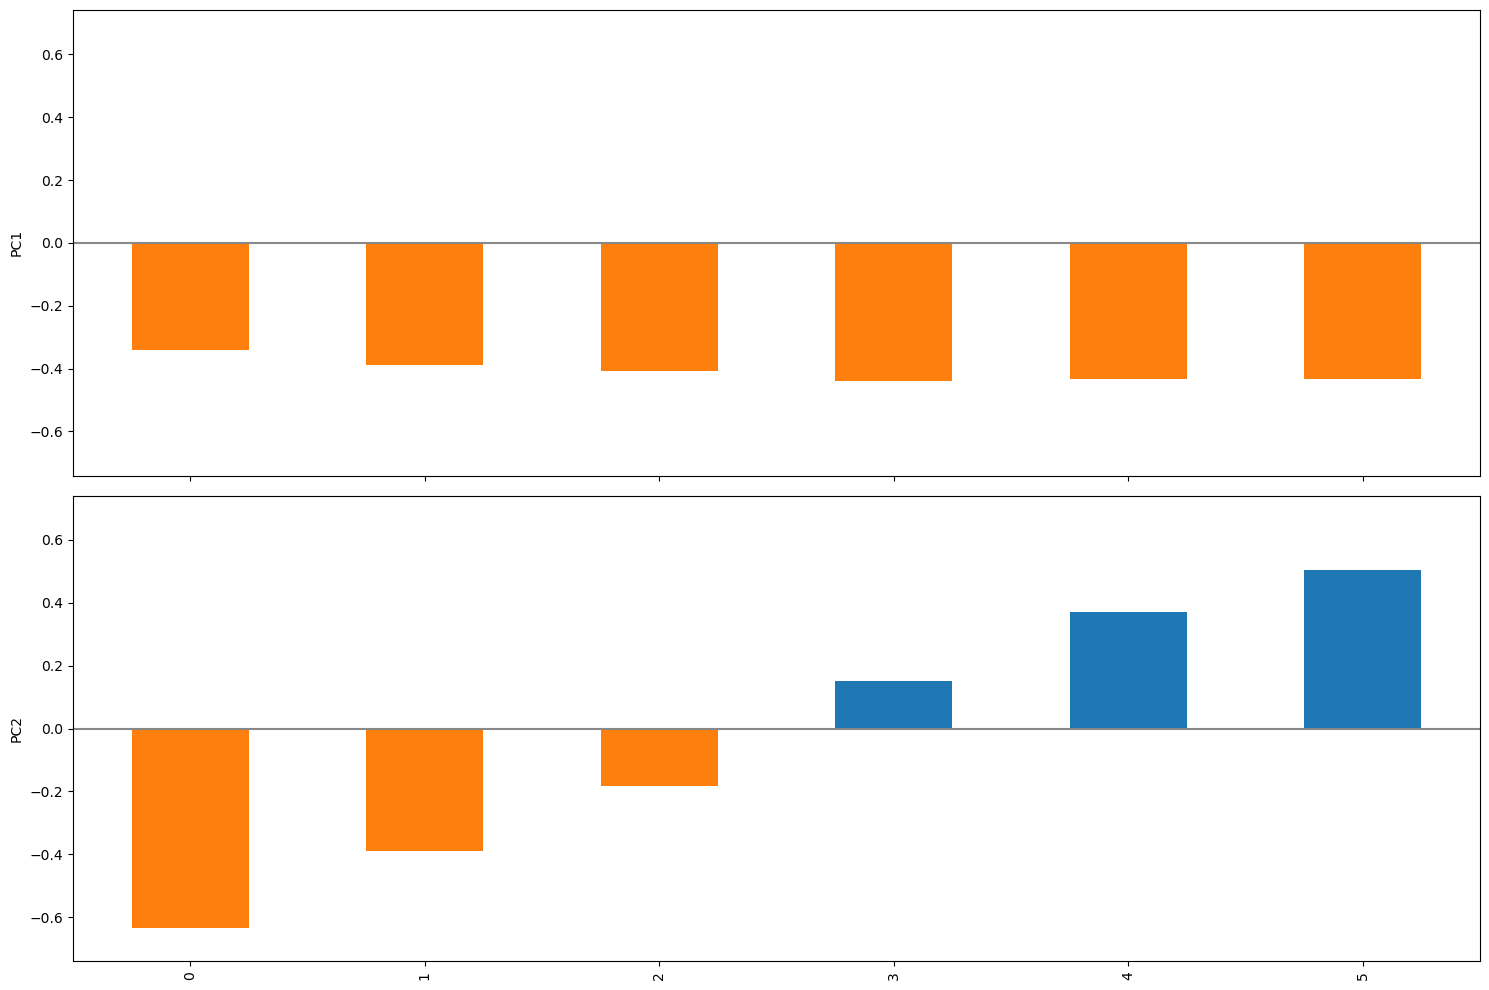

In [8]:
# n_components is the number of components we want to include for our model

def plot_loadings(data, n_components):
    """Plot the loadings of principal components from a given DataFrame.

    Parameters:
    - data (pd.DataFrame): The input data, which should include a 'date' column and
      columns for the securities to be analyzed.
    - n_components (int): The number of principal components to use for the analysis.

    Returns:
    - None

    This function applies PCA to the input data and plots the loadings of the first
    `n_components` principal components. The loadings show the correlations between
    the original securities and the principal components.

    The function first scales the data to the range [-1, 1] using MinMaxScaler. It then
    applies PCA using the specified number of components and calculates the explained
    variance ratio and singular values. Finally, it plots the loadings of each
    principal component using a bar chart. 
    """
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data_pca = scaler.fit_transform(data[data.columns[1:]])
    
    pca = PCA(n_components=n_components)
    opt_model = pca.fit(data_pca)
    
    print("Date Range: ", data.iloc[0]['date'].strftime('%Y-%m') + ' to ' + \
           data.iloc[-1]['date'].strftime('%Y-%m'))
    print("Singular Values: ", opt_model.singular_values_)
    print("Variance Explained by Each PC: ", opt_model.explained_variance_ratio_)
    print("Total Variance Explained: ", np.sum(opt_model.explained_variance_ratio_))

    loadings = pd.DataFrame(pca.components_, columns=data_pca.dtype.names)
    print("Loadings: ", '\n', loadings)

    maxPC = 1.01 * np.max(np.max(np.abs(loadings), axis=0), axis=0)
    f, axes = plt.subplots(n_components, 1, figsize=(15, 10), sharex=True)
    for i, ax in enumerate(axes):
        pc_loadings = loadings.loc[i, :]
        colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
        ax.axhline(color='#888888')
        pc_loadings.plot.bar(ax=ax, color=colors)
        ax.set_ylabel(f'PC{i+1}')
        ax.set_ylim(-maxPC - 0.1, maxPC + 0.1)
    plt.tight_layout()
    plt.show()
    

plot_loadings(data, 2)

Now we can transform the data into the two principal components

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_pca = scaler.fit_transform(data[data.columns[1:]])
pca = PCA(n_components=2)
opt_model = pca.fit(data_pca)
data_transformed = pd.DataFrame(opt_model.transform(data_pca)).rename({0: "PC1", 1: "PC2"}, axis = 1)

# data_trans_date is the dataframe of transformed data with the date column
data_trans_date = pd.DataFrame(data.date).join(data_transformed)
data_trans_date

,date,PC1,PC2
0,1976-07-01,0.143469,0.092325
1,1976-08-01,0.181236,0.045701
2,1976-09-01,0.206788,-0.015341
3,1976-10-01,0.367373,0.046363
4,1976-11-01,0.223878,-0.026863
...,...,...,...
554,2022-09-01,-0.757139,0.090176
555,2022-10-01,-0.574510,0.027103
556,2022-11-01,0.019330,-0.134983
557,2022-12-01,0.283779,-0.088295


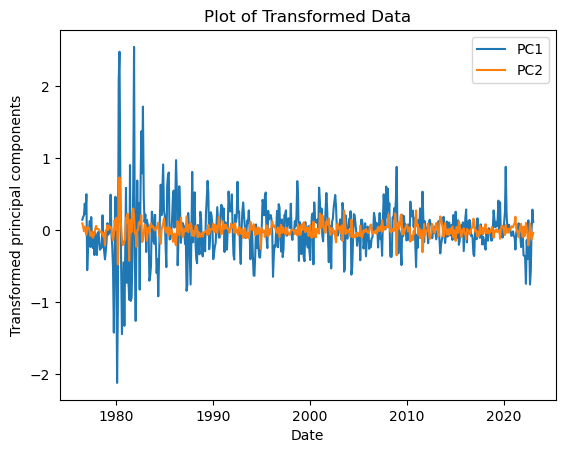

In [10]:
# plot of the transformed data
fig, ax = plt.subplots()

ax.plot(data_trans_date['date'], data_trans_date["PC1"], label="PC1")
ax.plot(data_trans_date['date'], data_trans_date["PC2"], label="PC2")

# set axis labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Transformed principal components')
plt.title('Plot of Transformed Data')
ax.legend()
plt.show()

### Test the stability of the model

In [11]:
def split_data(data, num_subsets, overlap):
    """
    Split the given data into a specified number of subsets with overlaps.

    Parameters:
    - data (pandas.DataFrame): The input data to be split.
    - num_subsets (int): The number of subsets to create.
    - overlap (int): The number of overlapping observations(months) between each subset.

    Returns:
    - List of pandas.DataFrame: A list containing the split subsets of the input data.
    """
    subset_len = (data.shape[0] + 1 - overlap) // num_subsets
    data_list = []
    for i in range(0, num_subsets):
        if i == 0:
            subset = data.iloc[:subset_len + overlap]
        elif i == num_subsets - 1:
            subset = data.iloc[i * subset_len:]
        else:
            subset = data.iloc[i * subset_len : (i + 1) * subset_len + overlap]
        data_list.append(subset)
    return data_list

# The following line splits the data into 5 subsets with 36 months of overlap
subset_list = split_data(data, 5, 36)

In [12]:
for i in subset_list:
    print(i.shape) # shape (number of rows, number of columns) of each subset

(140, 7)
(140, 7)
(140, 7)
(140, 7)
(143, 7)


After we obtain the 5 subsets, we can plot the cumulative variance explained versus number of principle components chosen for each subset. The title of the each plot is the date range of the subset. For all subsets, the number of components chosen should be two based on the graphs below.

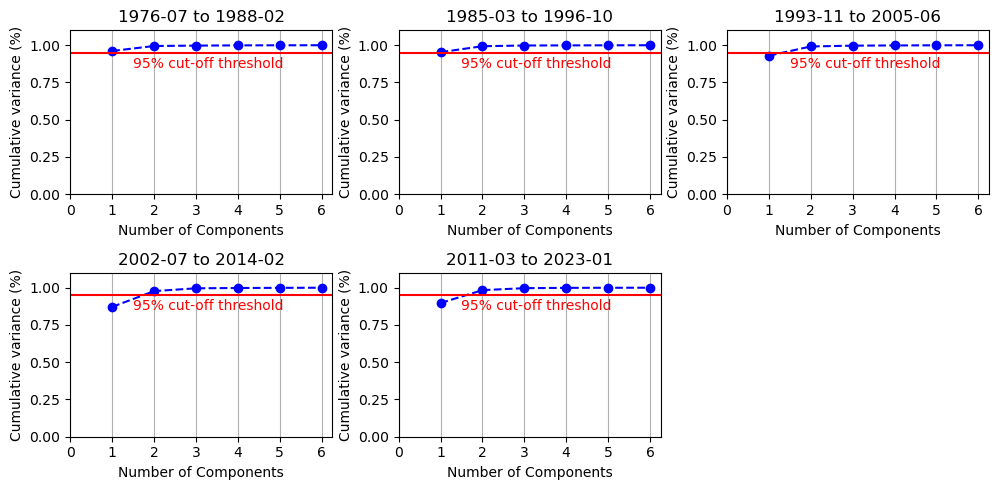

In [13]:
%matplotlib inline    
fig = plt.figure(figsize=(10, len(subset_list)))
for i in range(0, len(subset_list)):
    ax = fig.add_subplot((len(subset_list) + 2) // 3, 3, i+1)
    subset = subset_list[i]
    # call the previous function select_num_pc
    select_num_pc(subset)

plt.tight_layout()
plt.show()

Note: although the loadings of the second PC have opposite signs, their magnitudes agree with each other. We can conclude that the PCA model is consistent.

Date Range:  1976-07 to 1988-02
Singular Values:  [7.80718811 1.45774034]
Variance Explained by Each PC:  [0.96138852 0.03351737]
Total Variance Explained:  0.9949058941525208
Loadings:  
           0         1         2         3         4         5
0 -0.387684 -0.409683 -0.410761 -0.423121 -0.409441 -0.407999
1 -0.645290 -0.342917 -0.131513  0.170779  0.409423  0.501917


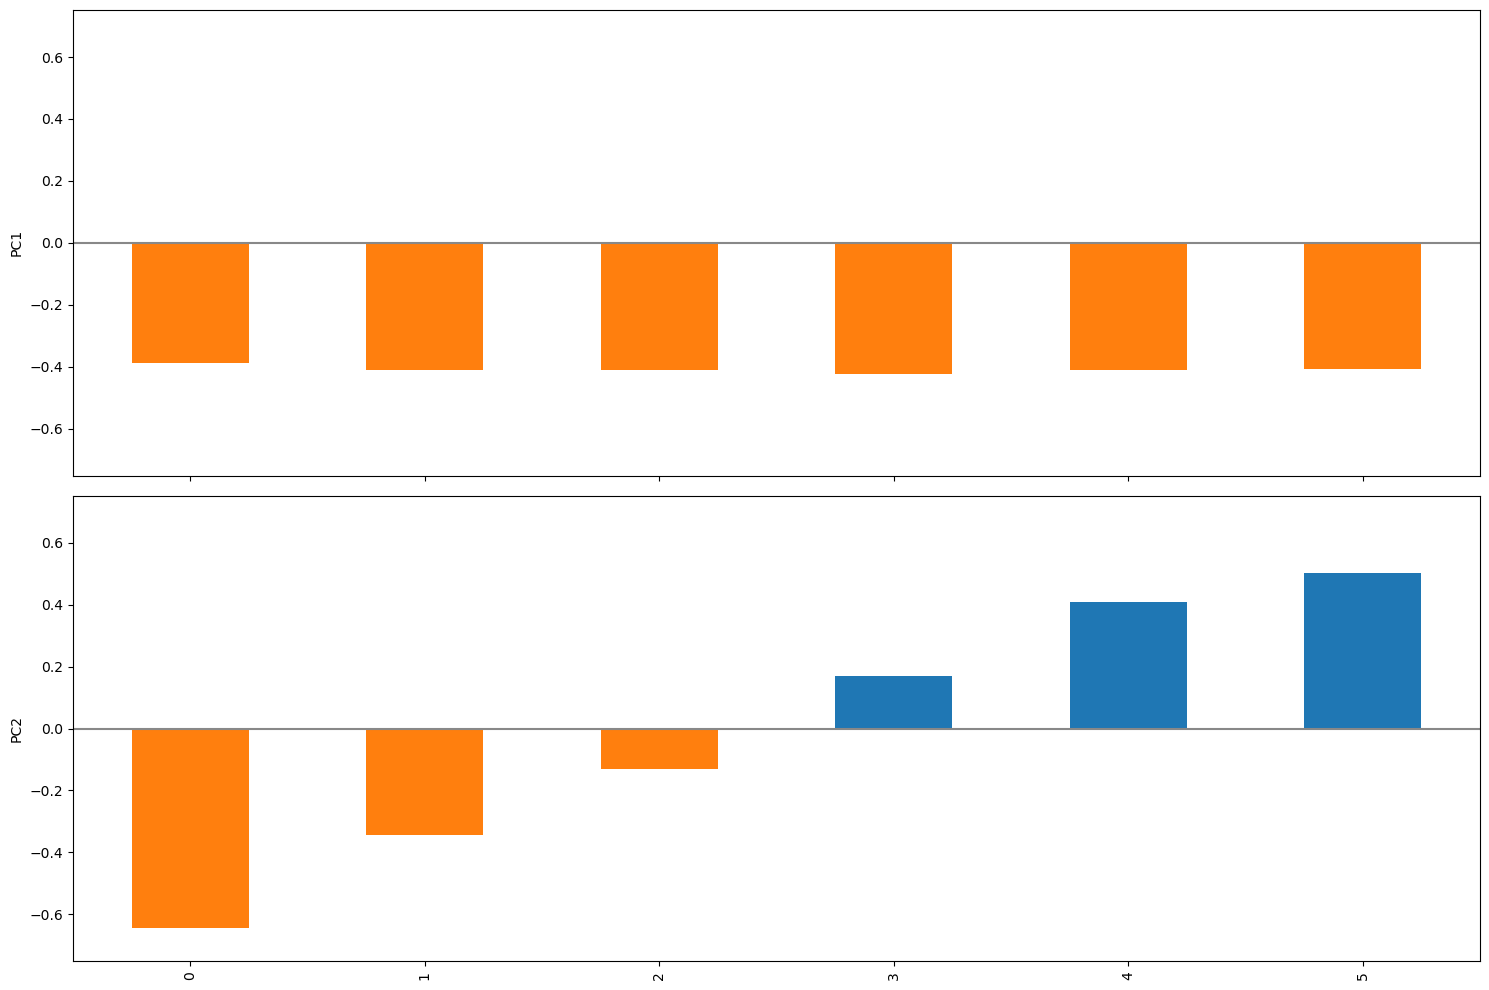

Date Range:  1985-03 to 1996-10
Singular Values:  [11.05095002  2.26714921]
Variance Explained by Each PC:  [0.95332303 0.04012371]
Total Variance Explained:  0.9934467403973184
Loadings:  
           0         1         2         3         4         5
0 -0.434501 -0.447168 -0.447179 -0.397278 -0.368436 -0.343083
1  0.679816  0.253955  0.015392 -0.242194 -0.391735 -0.510887


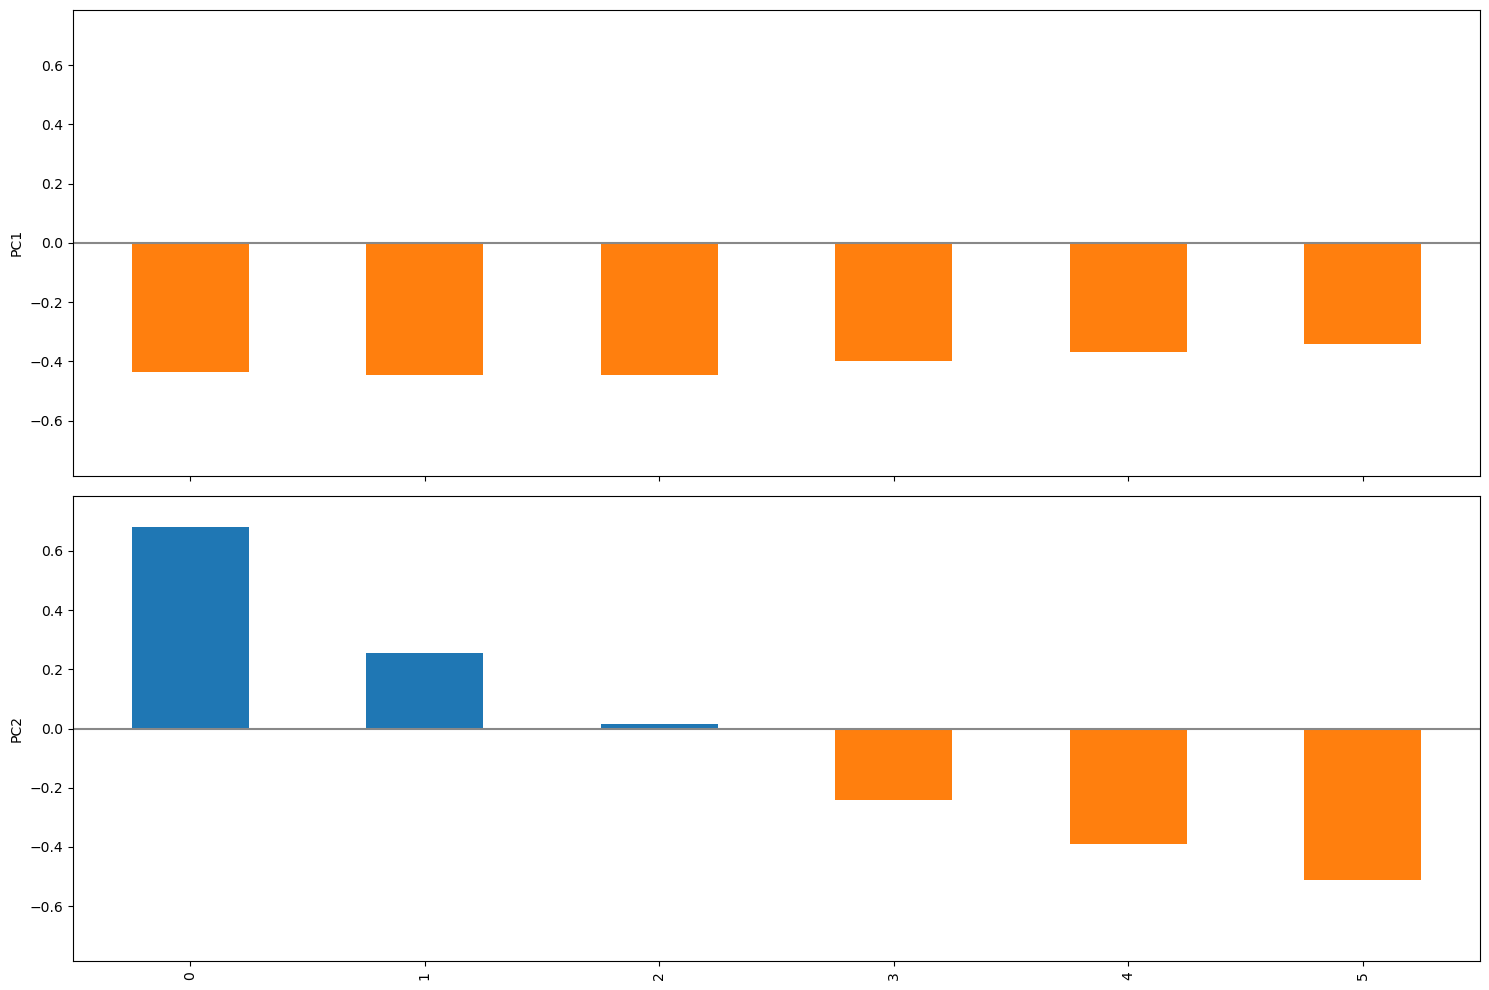

Date Range:  1993-11 to 2005-06
Singular Values:  [11.11463911  2.87494653]
Variance Explained by Each PC:  [0.9295511  0.06219308]
Total Variance Explained:  0.991744184514962
Loadings:  
           0         1         2         3         4         5
0 -0.293906 -0.418465 -0.441882 -0.440641 -0.428105 -0.407195
1  0.673255  0.377332  0.142649 -0.162936 -0.348520 -0.485783


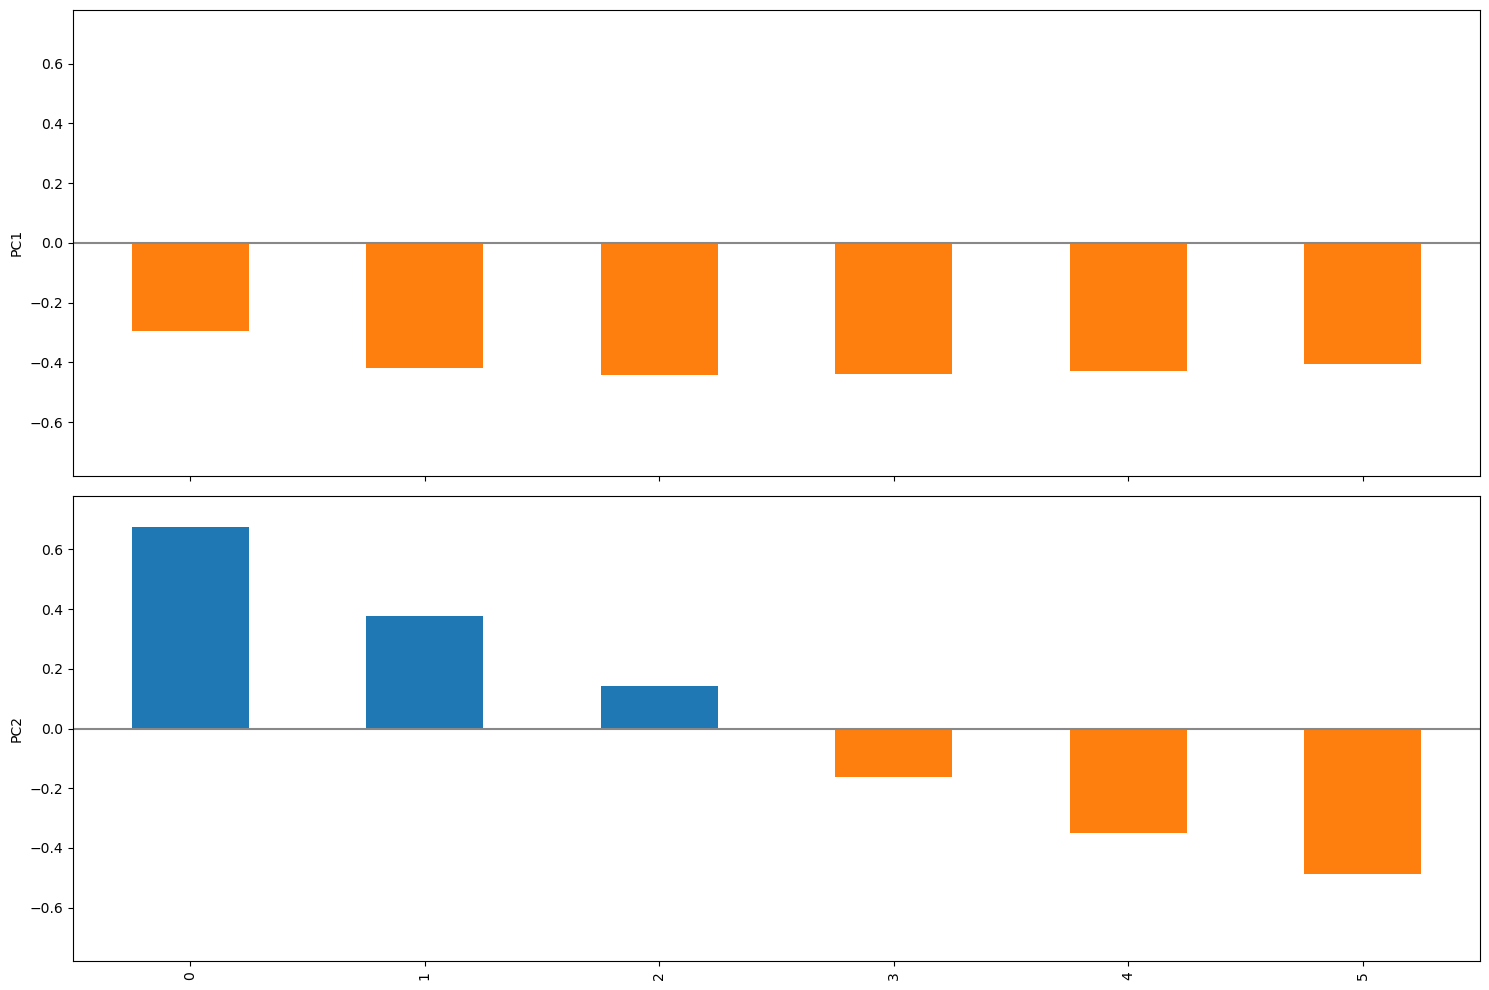

Date Range:  2002-07 to 2014-02
Singular Values:  [8.89686874 3.09724097]
Variance Explained by Each PC:  [0.87156935 0.10562764]
Total Variance Explained:  0.9771969924475125
Loadings:  
           0        1         2         3         4         5
0 -0.380053 -0.44669 -0.470779 -0.447731 -0.375213 -0.305200
1 -0.644716 -0.33549 -0.077736  0.317119  0.411867  0.442205


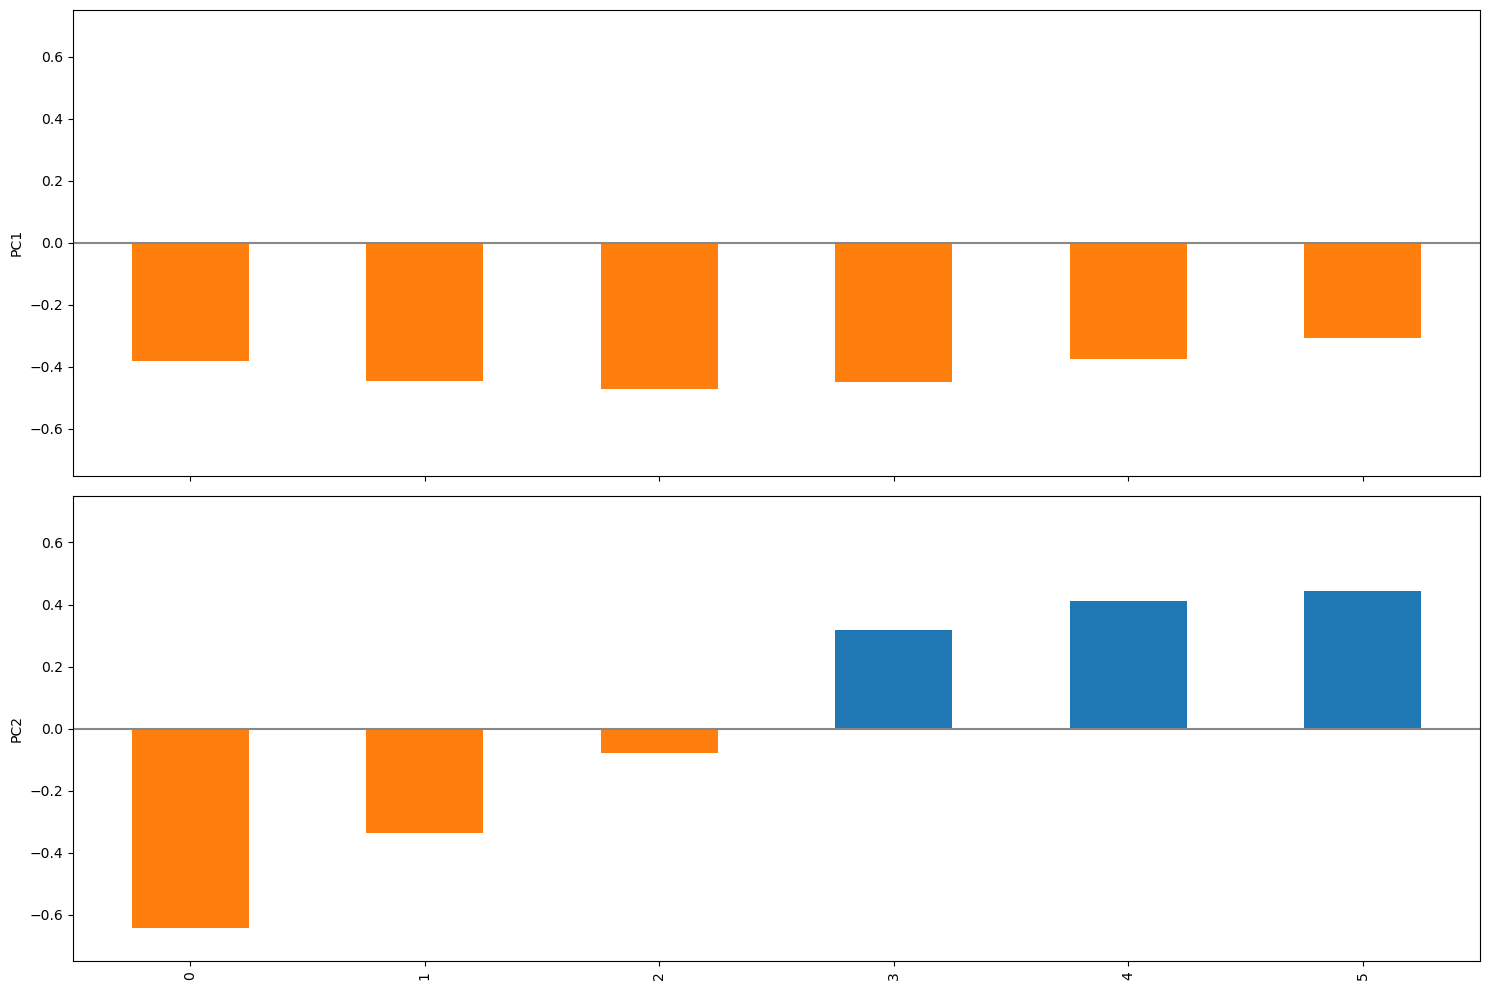

Date Range:  2011-03 to 2023-01
Singular Values:  [6.98261986 2.16796788]
Variance Explained by Each PC:  [0.8973518  0.08650309]
Total Variance Explained:  0.983854888905102
Loadings:  
           0         1         2         3         4         5
0 -0.249820 -0.333474 -0.387356 -0.453024 -0.494408 -0.476099
1 -0.638121 -0.465467 -0.264471  0.104058  0.339821  0.424134


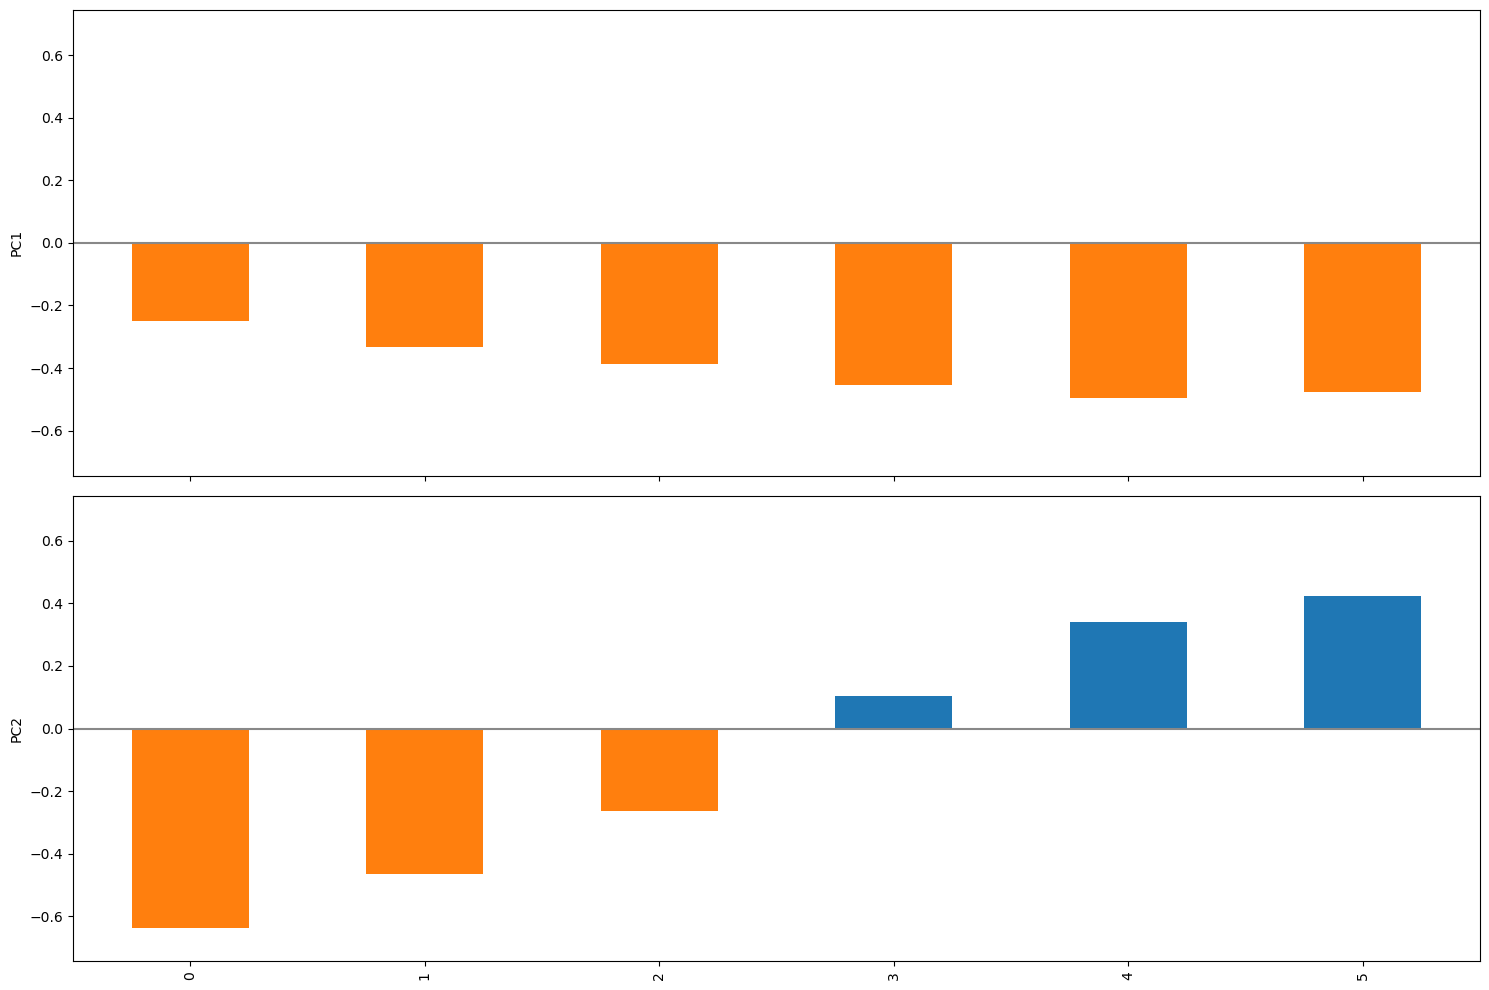

In [14]:
for subset in subset_list:
    plot_loadings(subset, 2)